<a href="https://colab.research.google.com/github/ShemMwanza/BERT-Disaster-Prediction-Model-using-Twitter-Data/blob/main/DistilBERT_Disaster_Prediction_Model_using_Twitter_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 43.7 MB/s 
     |████████████████████████████████| 182 kB 44.2 MB/s 


In [6]:
import torch 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import string
import re
from torch import nn
from torch.optim import AdamW
from tqdm.notebook import tqdm
from torchvision import transforms
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

from transformers import DistilBertModel, DistilBertTokenizer


In [9]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datapath = f'/content/drive/My Drive/Project_Dataset/train.csv'
df = pd.read_csv(datapath)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df = df.drop(['id','keyword','location'],axis=1)
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


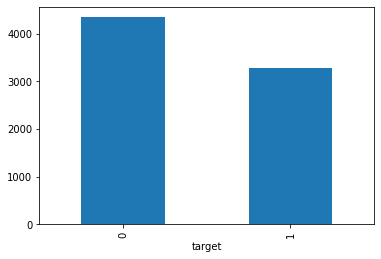

In [ ]:
df.groupby(['target']).size().plot.bar()

In [10]:
datapath2 = f'/content/drive/My Drive/Project_Dataset/test.csv'
df_test = pd.read_csv(datapath2)
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
df_test = df_test.drop(['keyword','location'],axis=1)
df_test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


# **Data Cleaning**

In [12]:
def remove_URLs(text):  #removing URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emojis(text):  #removing emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF'  
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        u'\U00010000-\U0010ffff'
        ']+', # emoticons, symbols etc
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuations(text): #removing punctuations
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_html_data(text):   #removing HTML data
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

    

In [ ]:
df['text'] = df['text'].apply(lambda x: remove_URLs(x))
df['text'] = df['text'].apply(lambda x: remove_emojis(x))
df['text'] = df['text'].apply(lambda x: remove_html_data(x))
df['text'] = df['text'].apply(lambda x: remove_punctuations(x))
df['text'] = df['text'].apply(str.lower)

In [ ]:
df.head(800)

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1
...,...,...
795,cleveland heights shaker heights fight bligh...,0
796,if you are going to achieve excellence in big ...,0
797,hendy21 sure the purdies will be alive with th...,0
798,tracy blight thank you for following me,0


# Data Cleaning Test Set

In [13]:
df_test['text'] = df_test['text'].apply(lambda x: remove_URLs(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_emojis(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_html_data(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punctuations(x))
df_test['text'] = df_test['text'].apply(str.lower)

# Splitting Dataset to obtain Train and Validation sets

In [ ]:
df_train, df_validation = np.split(df.sample(frac=1), [int(.8*len(df))])
print(len(df_train),len(df_validation))

6090 1523


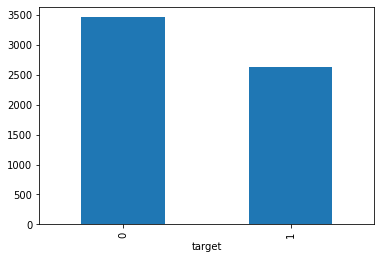

In [ ]:
df_train.groupby(['target']).size().plot.bar()

In [14]:
#seed
np.random.seed(112)
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_cuda = torch.cuda.is_available()
print(device)



cpu


In [15]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [16]:
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Dataset Class

In [17]:

class Dataset(torch.utils.data.Dataset):

  def __init__(self, df, tokenizer, istrain=True):
    self.tokenizer = tokenizer
    self.istrain = istrain
    if self.istrain:
        self.text = df['text'].values
        self.labels = df['target'].values
    else:
        self.text = df

  def __len__(self):
    if self.istrain:
        return len(self.labels)
    else:
        return len(self.text)


  def __getitem__(self, index):
    text = self.text[index]
    if self.istrain:
        labels = self.labels[index]

    inputs = self.tokenizer.encode_plus(text, max_length=50, padding='max_length',return_token_type_ids=False, truncation=True)
    input_ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    
    if self.istrain:
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long)
        }
    else:
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
        }


# Model Class

In [18]:

class DistilBertClass(nn.Module):

  def __init__(self, distilbert):
    super(DistilBertClass, self).__init__()
    self.distilbert = distilbert
    self.out_1 = nn.Linear(768, 768)
    self.dropout = nn.Dropout(0.5)
    self.relu = nn.ReLU()
    self.out = nn.Linear(768, 2)

  def forward(self, input_ids, mask):
    pooled_output = self.distilbert(input_ids=input_ids, attention_mask=mask)
    hidden_state = pooled_output[0]
    pooler = hidden_state[:, 0]
    pooler = self.out_1(pooler)
    pooler = self.relu(pooler)
    pooler = self.dropout(pooler)
    output = self.out(pooler)
    return output


# Accuracy and Loss graph


In [ ]:
import matplotlib.pyplot as plt
#Accuracy and Loss graph function
def accuracy_loss_graph(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    

In [ ]:
model = DistilBertClass(distilbert)
model = model.to(device)
model

DistilBertClass(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

# Train Function

In [ ]:
# Train function
def train(model, df_train, df_validation, learning_rate, epochs,batch_size):
    #Creating empty Dicts that will store values for plotting graphs
    results = {
            'train_loss': [],
            'valid_loss': [],
            'train_accuracy': [],
            'valid_accuracy': [],
    }
    best_val_loss = np.inf
    # creating Train Dataset and DataLoader
    train_dataset = Dataset(df_train,tokenizer = tokenizer, istrain = True)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle = True,
    )
    # creating Validation Dataset and DataLoader
    valid_dataset = Dataset(df_validation,tokenizer = tokenizer, istrain = True
    )
    val_dataloader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size = batch_size,
        shuffle = True,
    )
    
    # Loss
    criterion = nn.CrossEntropyLoss().to(device)
    if use_cuda:
        model = model.cuda()
    # optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.StepLR(
        optimizer,
        step_size = 4,
        gamma = 0.8
    )

    for epoch in range(epochs):
        print(f'Epochs: {epoch + 1}')
        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        # training model on training dataset
        model.train()
        for i, data in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):

            mask = data["mask"].to(device, dtype=torch.long)
            input_ids = data["input_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.long)

            optimizer.zero_grad()

            output = model.forward(input_ids=input_ids, mask=mask)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            output_class = torch.sigmoid(output).argmax(dim=1)
            train_acc += (output_class == labels).sum().item()/len(output)
        with torch.no_grad():
            # evaluating model on validation dataset
            model.eval()
            for i, data in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
            
                mask = data["mask"].to(device, dtype=torch.long)
                input_ids = data["input_ids"].to(device, dtype=torch.long)
                labels = data["labels"].to(device, dtype=torch.long)

                output = model.forward(input_ids=input_ids, mask=mask)
                loss = criterion(output, labels)

                valid_loss += loss.item()

                output_class = torch.sigmoid(output).argmax(dim=1)
                valid_acc += (output_class == labels).sum().item()/len(output)

            # calculating losses
            train_loss = train_loss / len(train_dataloader)
            valid_loss = valid_loss / len(val_dataloader)

            # calculating accuracy
            train_acc = train_acc / len(train_dataloader)
            valid_acc = valid_acc / len(val_dataloader)

            # Saving Model
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                print('Saving the Model now!!')
                torch.save(model, '/content/drive/My Drive/Project_Dataset' + '/'+ 'Distil_model' + '.bin')

            # storing losses and accuracy
            results['train_loss'].append(train_loss)
            results['valid_loss'].append(valid_loss)
            results['train_accuracy'].append(train_acc)
            results['valid_accuracy'].append(valid_acc)
            print(f'Epochs: {epoch + 1} | Train Loss: {train_loss: .3f} \ | Train Accuracy: {train_acc: .3f} \
                          | Val Loss: {valid_loss: .3f} \
                          | Val Accuracy: {valid_acc: .3f} \n')
            scheduler.step()
            accuracy_loss_graph(results['train_loss'], results['train_accuracy'], results['valid_loss'], results['valid_accuracy'])


# Prediction Function


In [19]:
#Model prediction function
def predict(model, data, batch_size):

    dataset = Dataset(data, tokenizer=tokenizer, istrain=False)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
    )
    y_pred = []
    use_cuda = torch.cuda.is_available()

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():

        for i, data in tqdm(enumerate(dataloader), total= len(dataloader)):
              mask = data["mask"].to(device, dtype=torch.long)
              input_ids = data["input_ids"].to(device, dtype=torch.long)

              output = model(input_ids, mask)

              prob_max, predicted = torch.max(output, 1)

              predicted = predicted.detach().cpu().numpy()
              y_pred.extend(predicted)
    #concatenating all batch predictions
    return np.concatenate([y_pred])

In [20]:
#Declaring of hyperparameters
learning_rate=1e-6
epochs = 16
batch_size = 32

Epochs: 1


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 1 | Train Loss:  0.669 \ | Train Accuracy:  0.606                           | Val Loss:  0.623                           | Val Accuracy:  0.747 

Epochs: 2


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 2 | Train Loss:  0.575 \ | Train Accuracy:  0.750                           | Val Loss:  0.500                           | Val Accuracy:  0.802 

Epochs: 3


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 3 | Train Loss:  0.484 \ | Train Accuracy:  0.793                           | Val Loss:  0.437                           | Val Accuracy:  0.818 

Epochs: 4


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 4 | Train Loss:  0.441 \ | Train Accuracy:  0.812                           | Val Loss:  0.410                           | Val Accuracy:  0.833 

Epochs: 5


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 5 | Train Loss:  0.417 \ | Train Accuracy:  0.825                           | Val Loss:  0.404                           | Val Accuracy:  0.834 

Epochs: 6


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 6 | Train Loss:  0.406 \ | Train Accuracy:  0.831                           | Val Loss:  0.398                           | Val Accuracy:  0.839 

Epochs: 7


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 7 | Train Loss:  0.392 \ | Train Accuracy:  0.839                           | Val Loss:  0.394                           | Val Accuracy:  0.838 

Epochs: 8


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epochs: 8 | Train Loss:  0.384 \ | Train Accuracy:  0.841                           | Val Loss:  0.396                           | Val Accuracy:  0.835 

Epochs: 9


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 9 | Train Loss:  0.374 \ | Train Accuracy:  0.847                           | Val Loss:  0.391                           | Val Accuracy:  0.838 

Epochs: 10


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 10 | Train Loss:  0.366 \ | Train Accuracy:  0.850                           | Val Loss:  0.390                           | Val Accuracy:  0.841 

Epochs: 11


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epochs: 11 | Train Loss:  0.361 \ | Train Accuracy:  0.850                           | Val Loss:  0.392                           | Val Accuracy:  0.839 

Epochs: 12


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epochs: 12 | Train Loss:  0.354 \ | Train Accuracy:  0.857                           | Val Loss:  0.395                           | Val Accuracy:  0.839 

Epochs: 13


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epochs: 13 | Train Loss:  0.352 \ | Train Accuracy:  0.856                           | Val Loss:  0.392                           | Val Accuracy:  0.837 

Epochs: 14


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saving the Model now!!
Epochs: 14 | Train Loss:  0.346 \ | Train Accuracy:  0.861                           | Val Loss:  0.390                           | Val Accuracy:  0.838 

Epochs: 15


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epochs: 15 | Train Loss:  0.343 \ | Train Accuracy:  0.865                           | Val Loss:  0.392                           | Val Accuracy:  0.835 

Epochs: 16


  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epochs: 16 | Train Loss:  0.336 \ | Train Accuracy:  0.868                           | Val Loss:  0.392                           | Val Accuracy:  0.839 



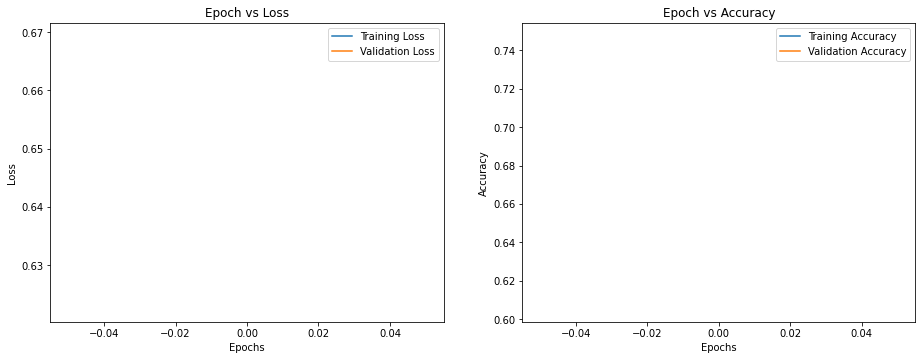

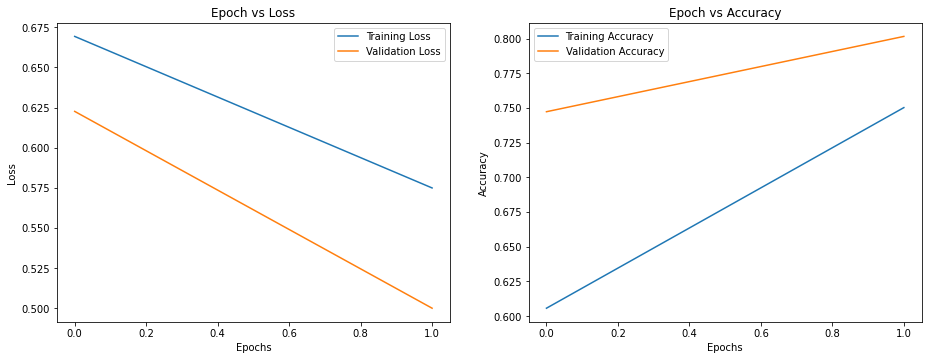

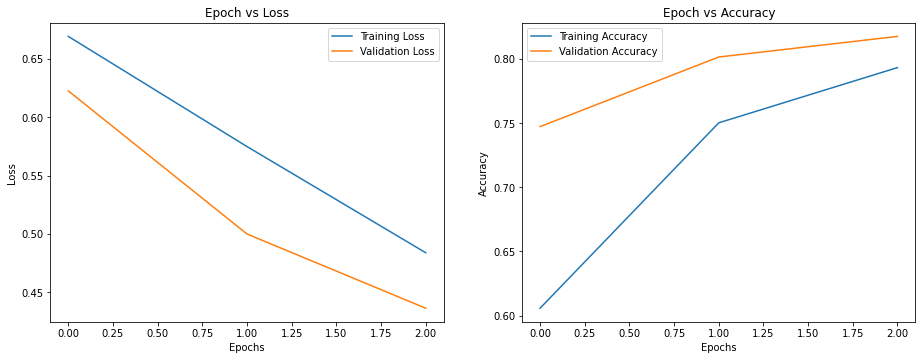

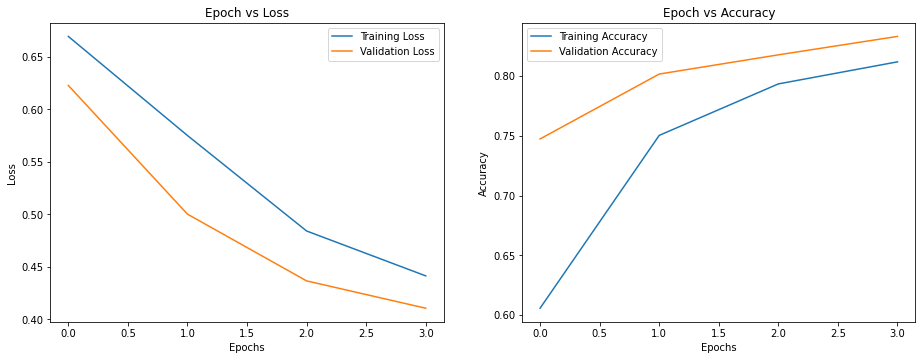

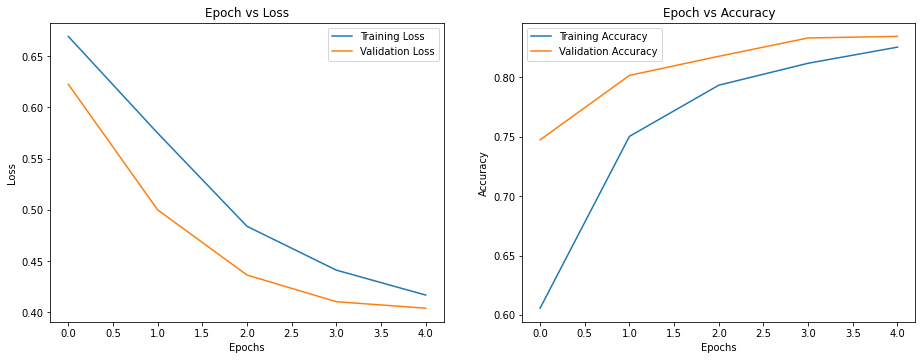

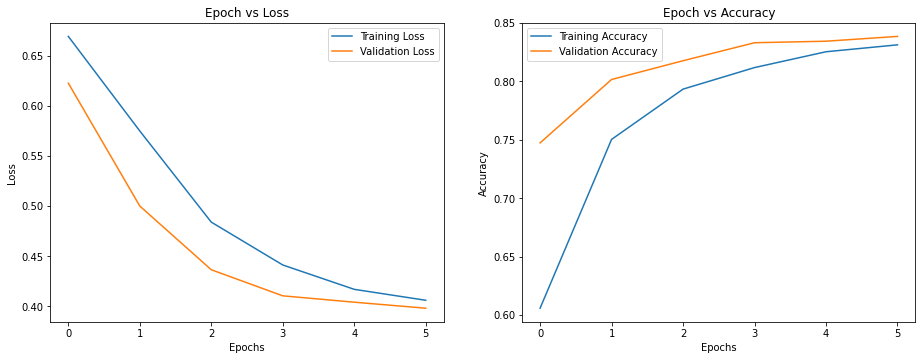

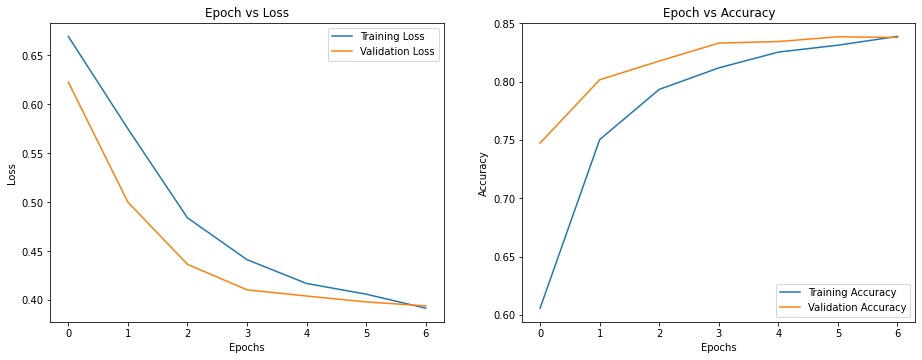

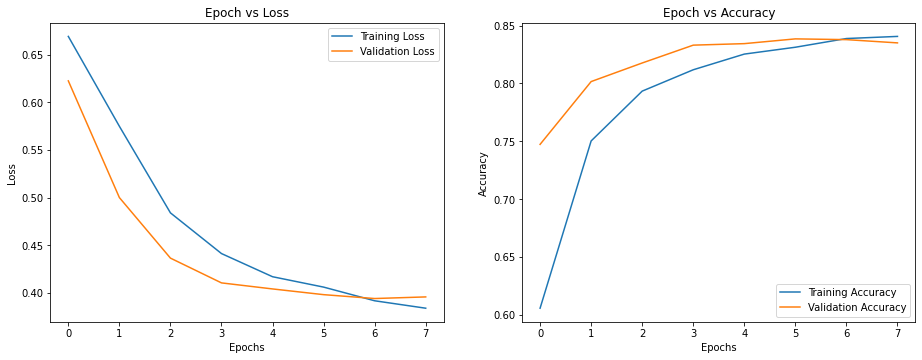

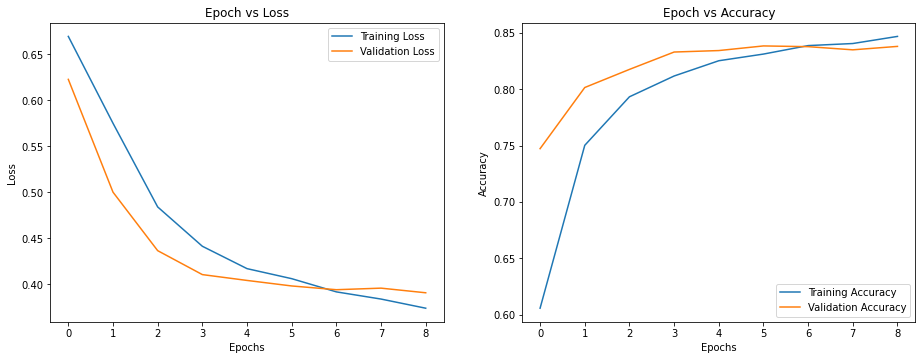

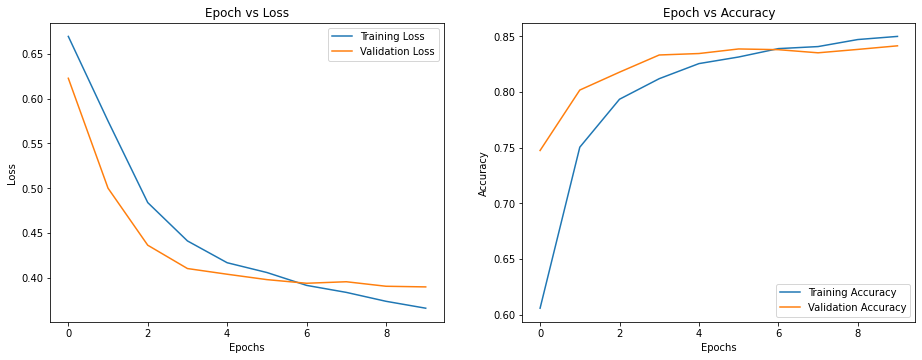

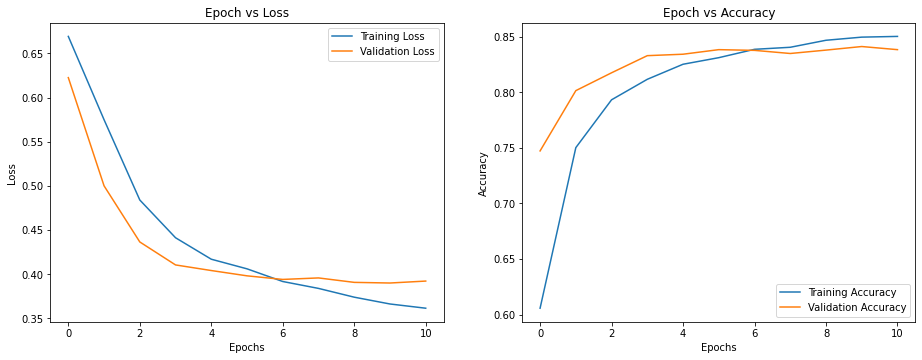

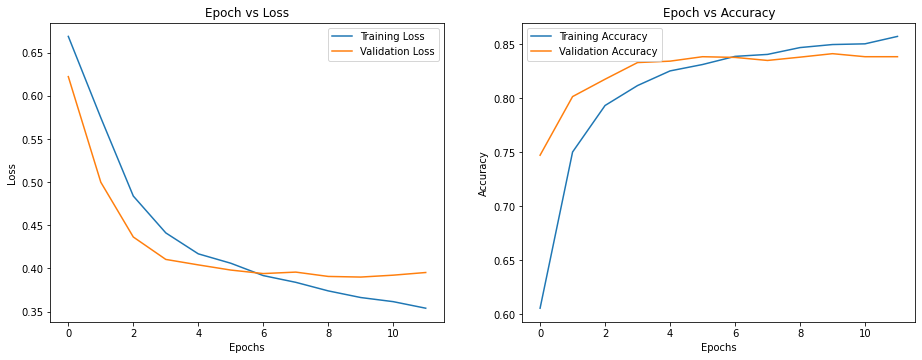

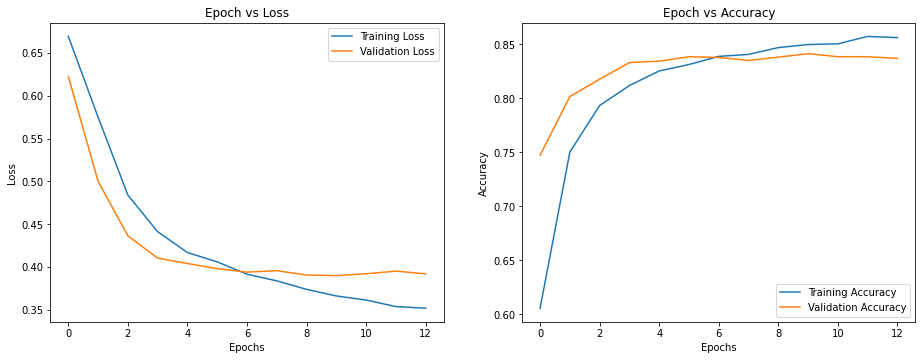

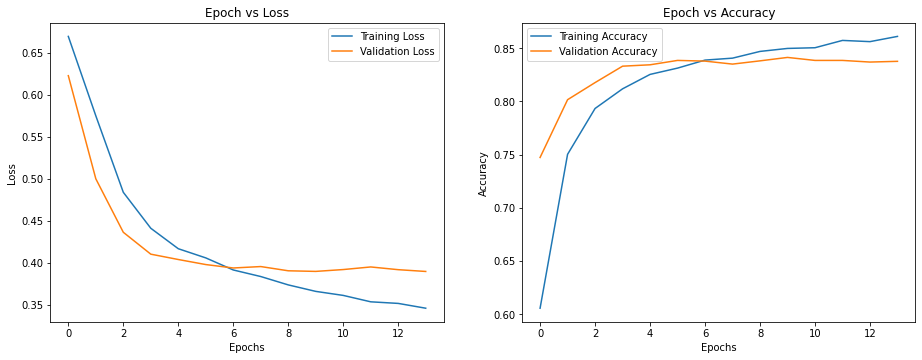

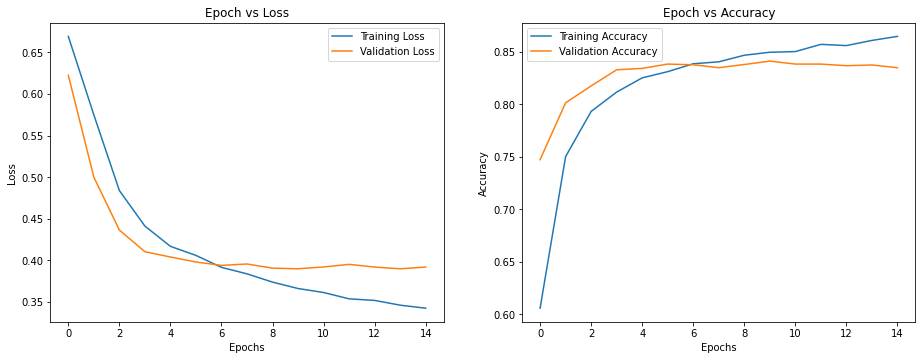

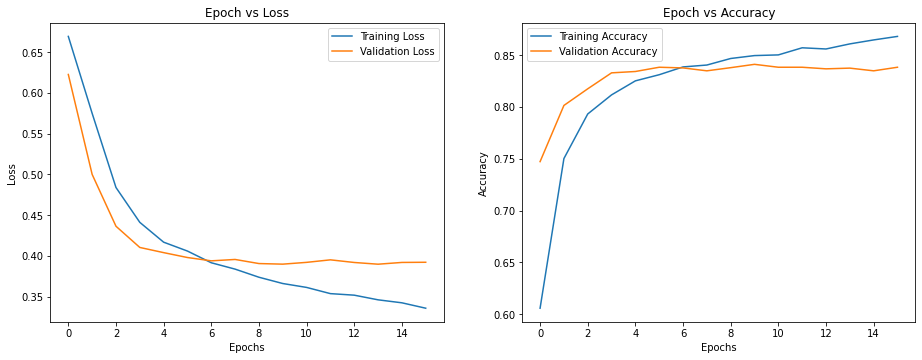

In [ ]:
train(model, df_train, df_validation, learning_rate, epochs, batch_size)

# Loading of saved model

In [21]:
model1 = torch.load("/content/drive/MyDrive/Project_Dataset/Distil_model.bin")

# Predicting on Validation Data

In [ ]:
predictions_val = predict(model1, df_validation['text'].values, batch_size)

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
predictions_val

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

val_actual = list(df_validation['target'])
val_predicted = list(predictions_val)

In [ ]:
#Confusion matrix results
results = confusion_matrix(val_actual, val_predicted) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(val_actual, val_predicted))
print('Report : ')
classification_report = classification_report(val_actual, val_predicted)
print(classification_report)

Confusion Matrix :
[[808  75]
 [166 474]]
Accuracy Score : 0.8417596848325674
Report : 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       883
           1       0.86      0.74      0.80       640

    accuracy                           0.84      1523
   macro avg       0.85      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523



# Prediction on test set

In [22]:
test_predictions = predict(model1, df_test['text'].values,batch_size)

  0%|          | 0/102 [00:00<?, ?it/s]

In [23]:
test_predictions

array([1, 1, 1, ..., 1, 1, 1])

# Save predictions to CSV

In [24]:
df1 = pd.DataFrame()
df1['text'] = df_test['text']
df1['target'] =  test_predictions.astype(int)

In [25]:
df1.to_csv('final.csv', index=False)
df1

,text,target
0,just happened a terrible car crash,1
1,heard about earthquake is different cities sta...,1
2,there is a forest fire at spot pond geese are ...,1
3,apocalypse lighting spokane wildfires,1
4,typhoon soudelor kills 28 in china and taiwan,1
...,...,...
3258,earthquake safety los angeles ûò safety faste...,0
3259,storm in ri worse than last hurricane my city3...,1
3260,green line derailment in chicago,1
3261,meg issues hazardous weather outlook hwo,1
